In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Load Data
data_path = '/content/Battery_RUL.csv'
df = pd.read_csv(data_path)
print(df.head())

# Data Preprocessing
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df.drop(columns=['RUL']))  # Assuming 'RUL' is the target variable
target = df['RUL'].values.reshape(-1, 1)
target_scaler = MinMaxScaler()
target_scaled = target_scaler.fit_transform(target)

# Creating Sequences
def create_sequences(data, target, seq_length=20):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(target[i + seq_length])
    return np.array(X), np.array(y)

seq_length = 20
X, y = create_sequences(scaled_data, target_scaled, seq_length)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# LSTM Model
lstm_model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(seq_length, X.shape[2])),
    Dropout(0.2),
    LSTM(32),
    Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))
lstm_model.save("lstm_model.h5")

# GRU Model
gru_model = Sequential([
    GRU(64, return_sequences=True, input_shape=(seq_length, X.shape[2])),
    Dropout(0.2),
    GRU(32),
    Dense(1)
])
gru_model.compile(optimizer='adam', loss='mse')
gru_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))
gru_model.save("gru_model.h5")

# Transformer-Based Model (Simple Implementation)
from tensorflow.keras.layers import LayerNormalization, MultiHeadAttention, Flatten

def build_transformer_model():
    inputs = tf.keras.Input(shape=(seq_length, X.shape[2]))
    x = MultiHeadAttention(num_heads=2, key_dim=32)(inputs, inputs)
    x = LayerNormalization()(x)
    x = Flatten()(x)
    x = Dense(32, activation='relu')(x)
    outputs = Dense(1)(x)
    model = tf.keras.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='mse')
    return model

transformer_model = build_transformer_model()
transformer_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))
transformer_model.save("transformer_model.h5")

# Model Evaluation
def evaluate_model(model, X_test, y_test, name):
    predictions = model.predict(X_test)
    predictions = target_scaler.inverse_transform(predictions)
    y_test = target_scaler.inverse_transform(y_test)
    plt.plot(y_test, label='True RUL')
    plt.plot(predictions, label=f'Predicted RUL ({name})')
    plt.legend()
    plt.title(f'Predictions vs Actual - {name}')
    plt.show()

evaluate_model(lstm_model, X_test, y_test, 'LSTM')
evaluate_model(gru_model, X_test, y_test, 'GRU')
evaluate_model(transformer_model, X_test, y_test, 'Transformer')

In [1]:
import pandas as pd

df = pd.read_csv('/content/Battery_RUL.csv')
print(df.shape)

(15064, 9)


## Data exploration

DataFrame Shape: (15064, 9)

Data Types:
 Cycle_Index                  float64
Discharge Time (s)           float64
Decrement 3.6-3.4V (s)       float64
Max. Voltage Dischar. (V)    float64
Min. Voltage Charg. (V)      float64
Time at 4.15V (s)            float64
Time constant current (s)    float64
Charging time (s)            float64
RUL                            int64
dtype: object

Descriptive Statistics:
         Cycle_Index  Discharge Time (s)  ...  Charging time (s)           RUL
count  15064.000000        15064.000000  ...       15064.000000  15064.000000
mean     556.155005         4581.273960  ...       10066.496204    554.194172
std      322.378480        33144.012077  ...       26415.354121    322.434514
min        1.000000            8.690000  ...           5.980000      0.000000
25%      271.000000         1169.310000  ...        7841.922500    277.000000
50%      560.000000         1557.250000  ...        8320.415000    551.000000
75%      833.000000         1908.000000

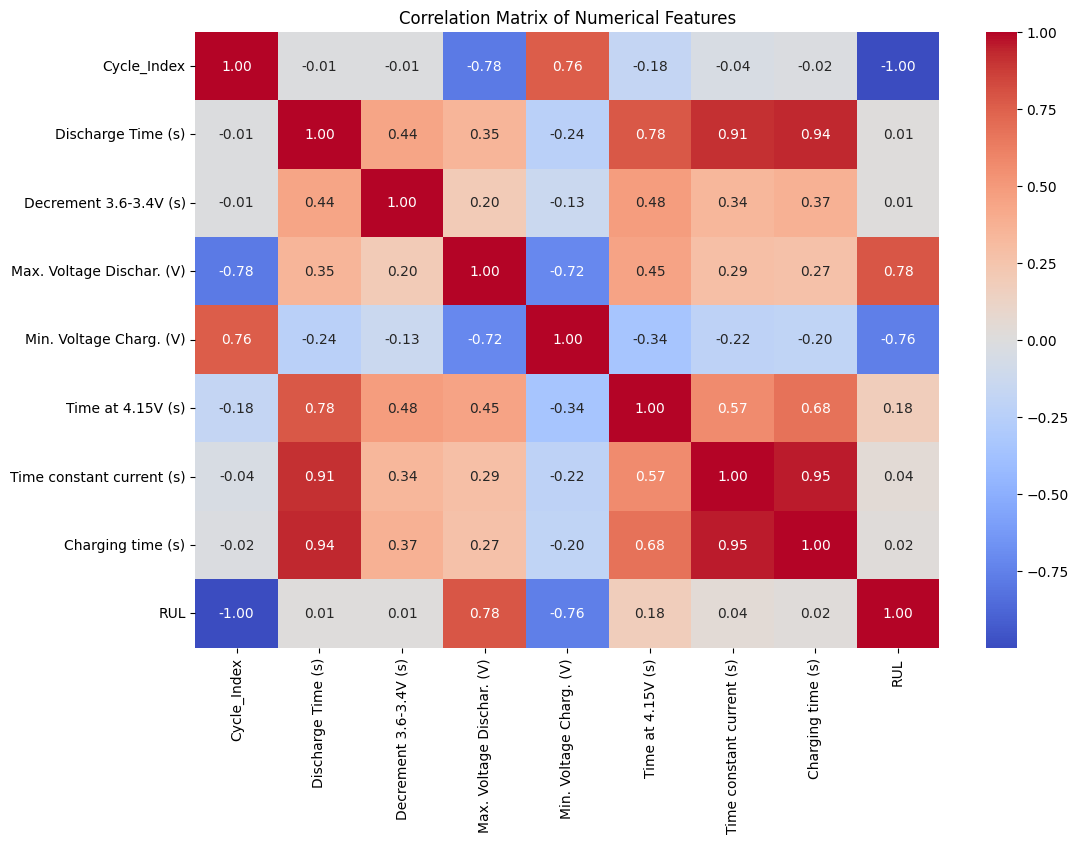

In [2]:
# 1. Data Shape and Types
print("DataFrame Shape:", df.shape)
print("\nData Types:\n", df.dtypes)

# 2. Descriptive Statistics
print("\nDescriptive Statistics:\n", df.describe())

# 3. Correlation Analysis
correlation_matrix = df.corr()
print("\nCorrelation Matrix:\n", correlation_matrix)

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numerical Features')
plt.show()

## EDA

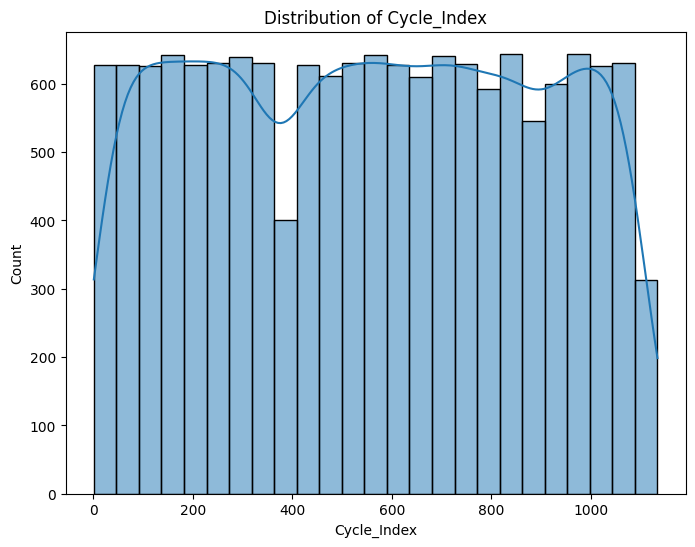

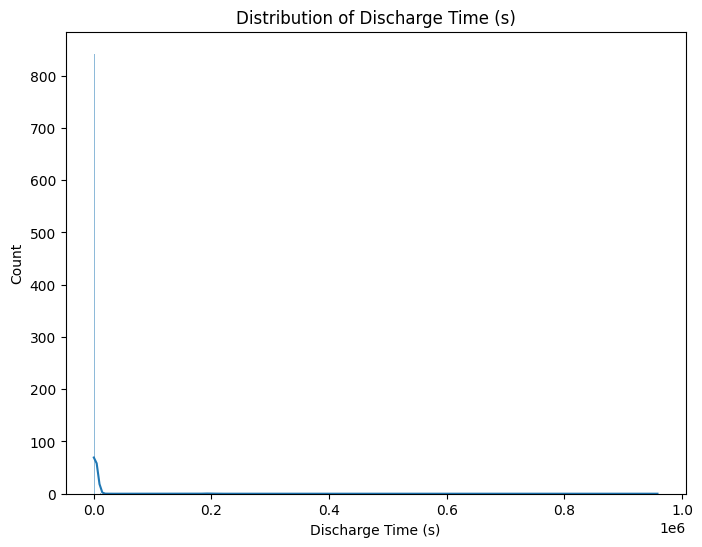

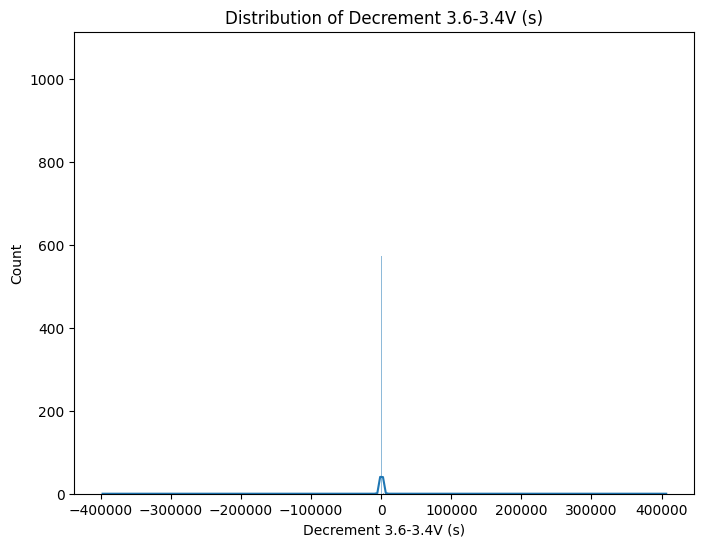

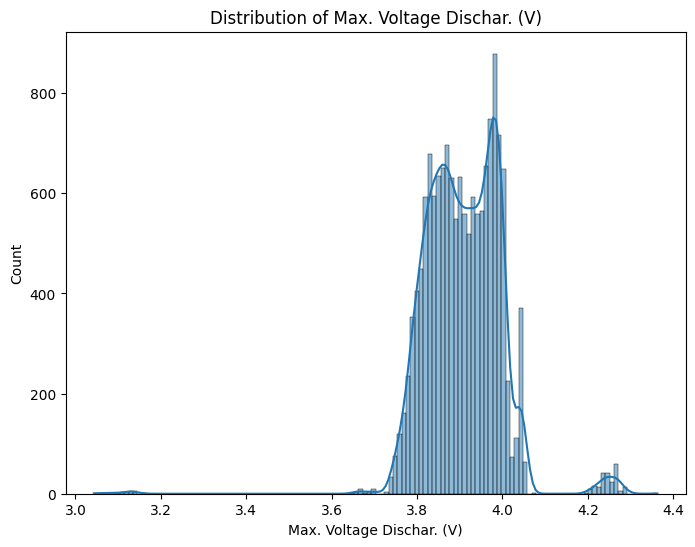

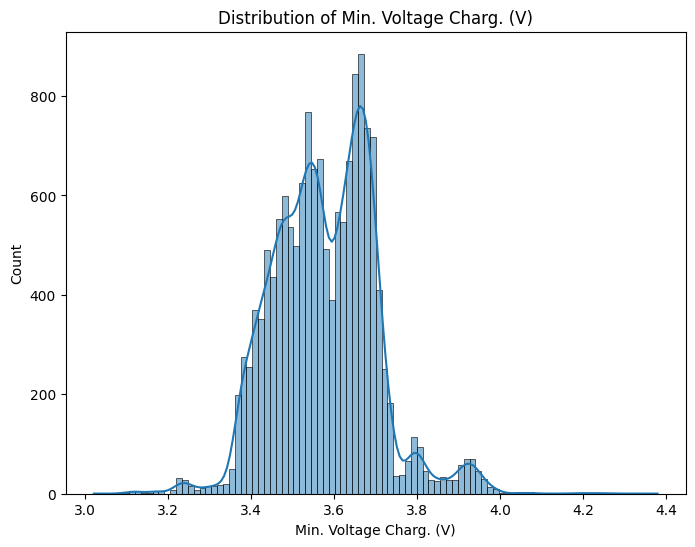

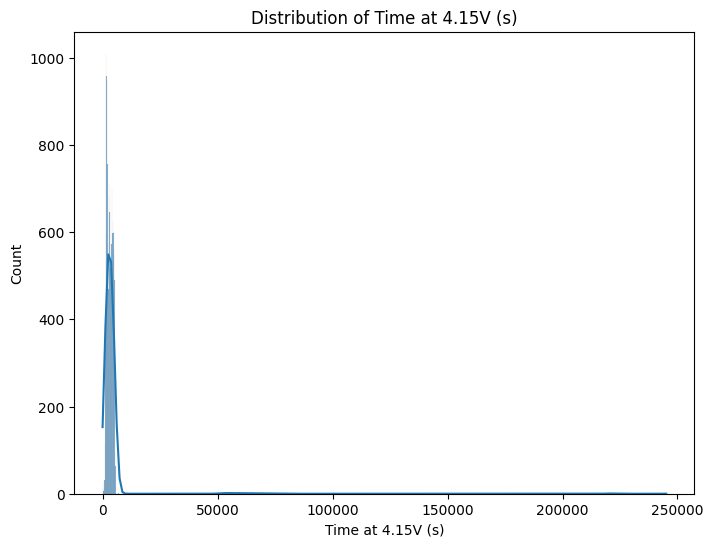

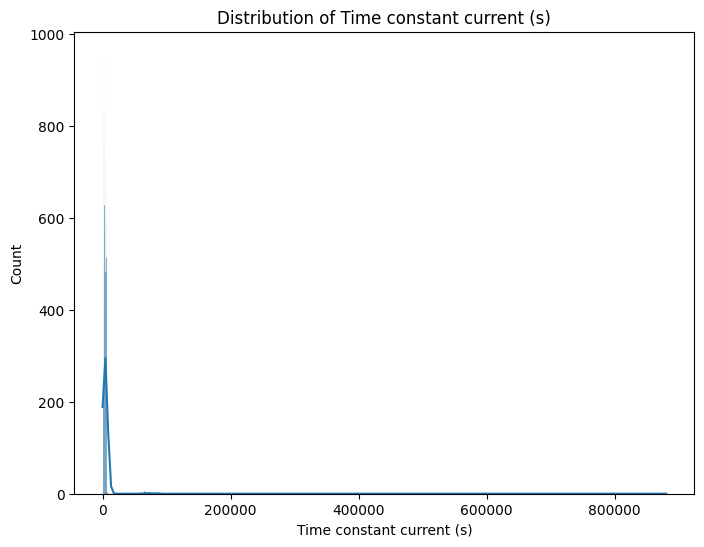

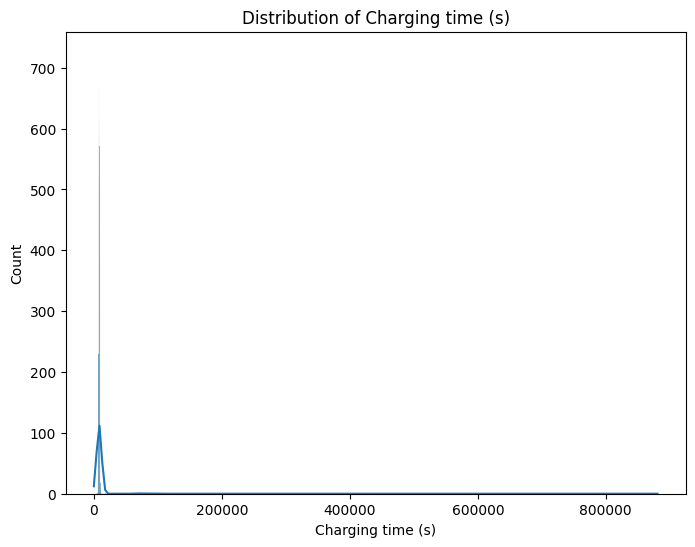

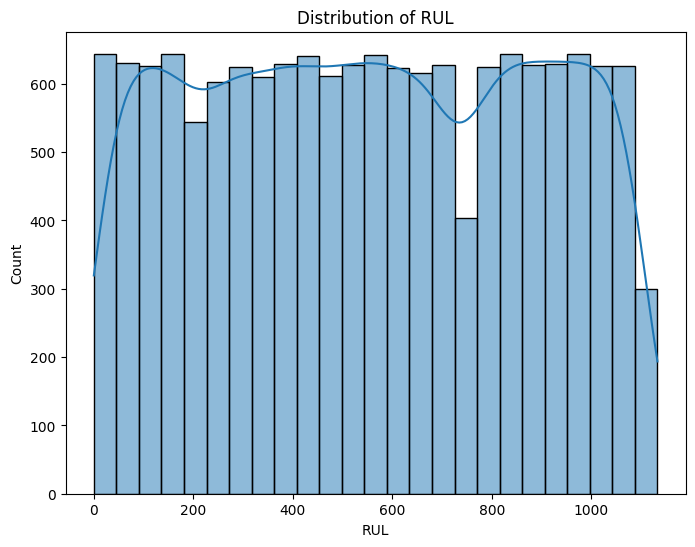

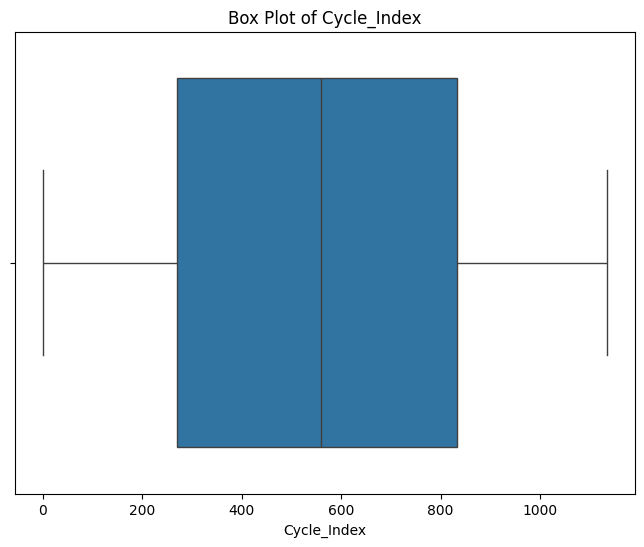

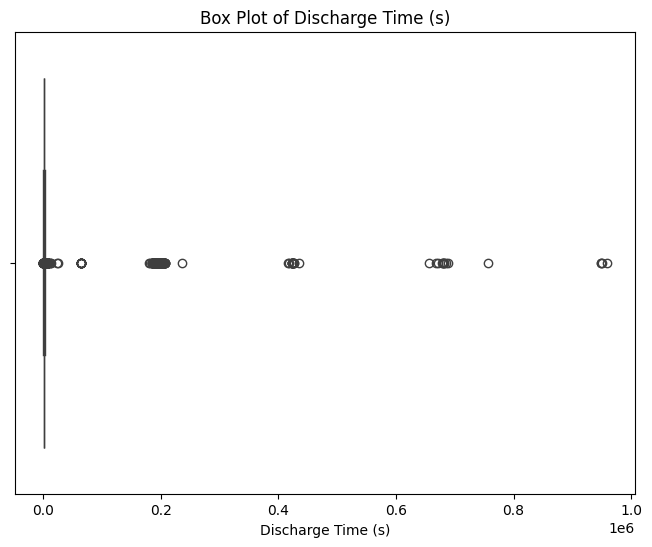

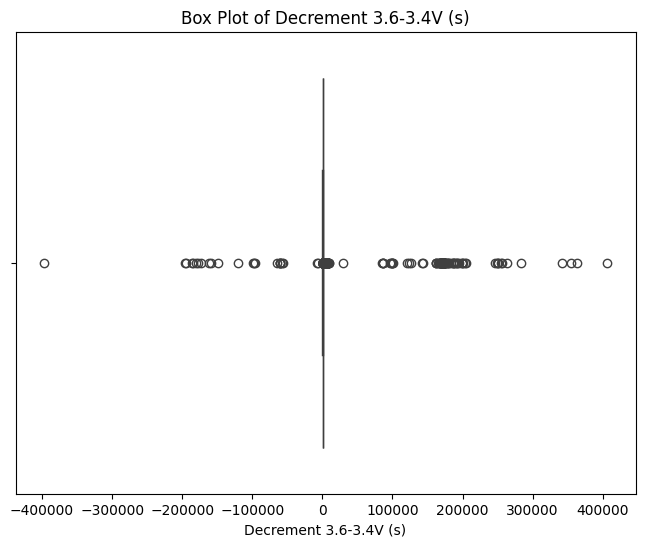

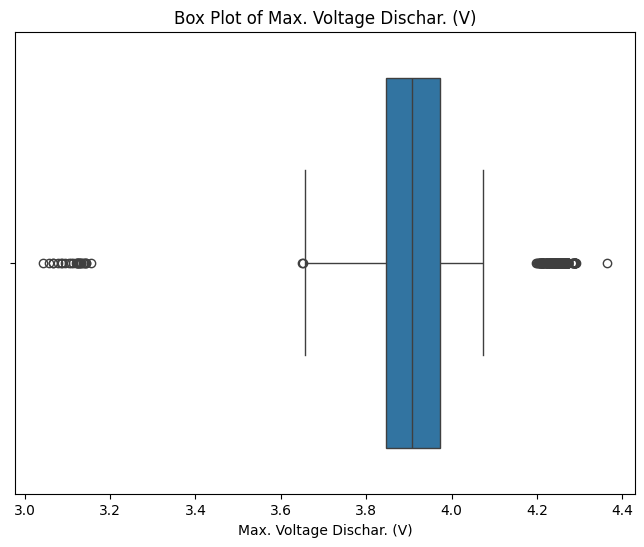

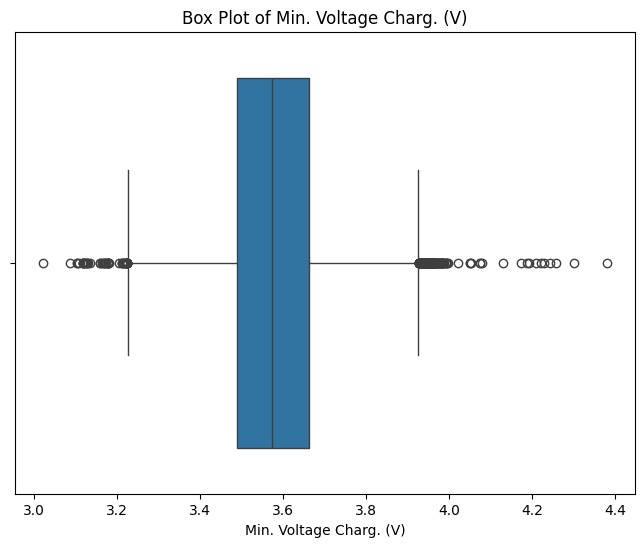

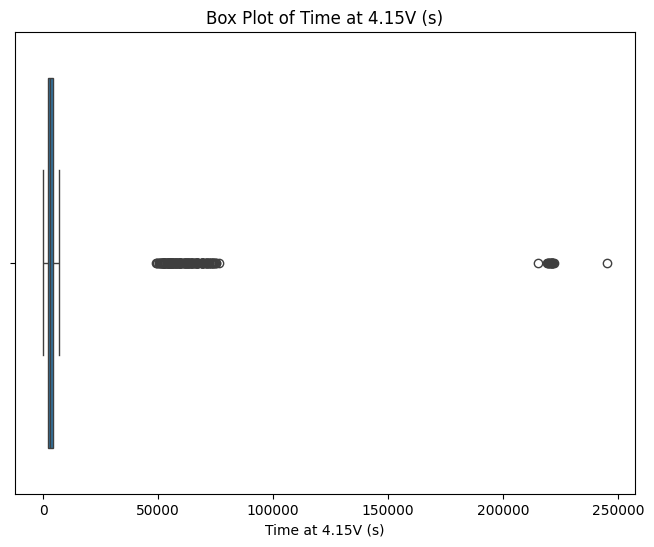

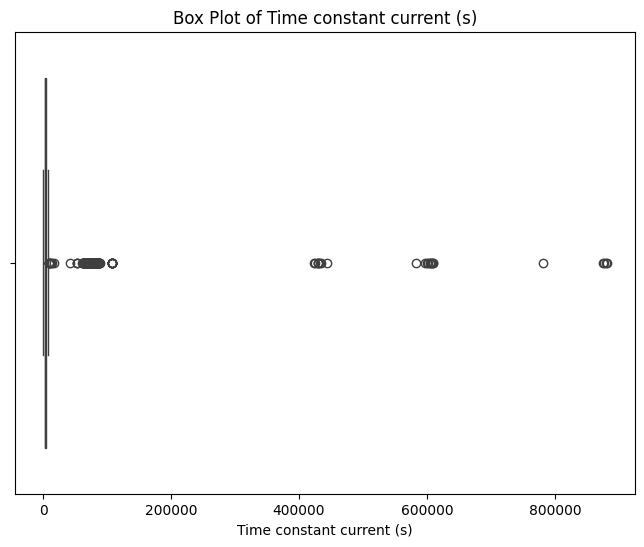

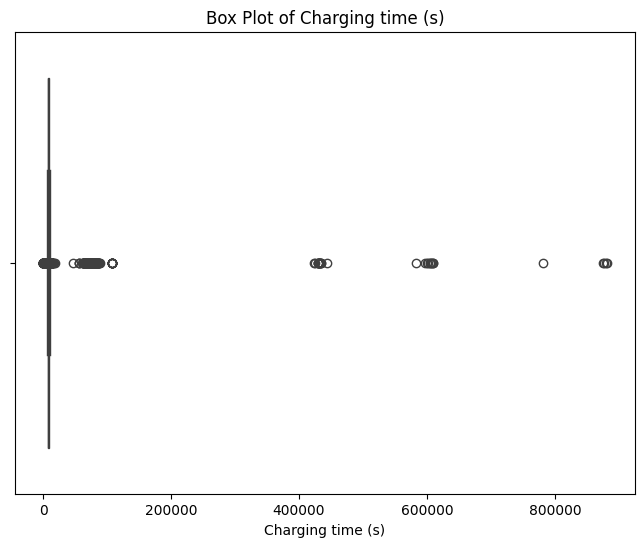

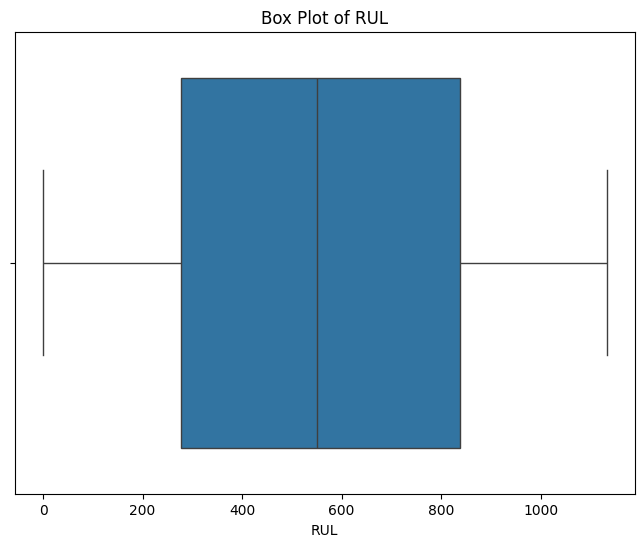

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

# 4. Distribution Analysis
numerical_features = df.select_dtypes(include=['float64', 'int64']).columns

# Histogram for each numerical feature
for feature in numerical_features:
    plt.figure(figsize=(8, 6))
    sns.histplot(df[feature], kde=True)
    plt.title(f'Distribution of {feature}')
    plt.show()

# Box plot for each numerical feature
for feature in numerical_features:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x=df[feature])
    plt.title(f'Box Plot of {feature}')
    plt.show()

## Data Cleaning

In [3]:
# Handle Missing Values
print("Missing values in each column:\n", df.isnull().sum())

# Handle Outliers (using IQR method for numerical features)
numerical_features = df.select_dtypes(include=['float64', 'int64']).columns
for feature in numerical_features:
  Q1 = df[feature].quantile(0.25)
  Q3 = df[feature].quantile(0.75)
  IQR = Q3 - Q1
  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR
  df = df[(df[feature] >= lower_bound) & (df[feature] <= upper_bound)]

# Handle Duplicates
df = df.drop_duplicates()

Missing values in each column:
 Cycle_Index                  0
Discharge Time (s)           0
Decrement 3.6-3.4V (s)       0
Max. Voltage Dischar. (V)    0
Min. Voltage Charg. (V)      0
Time at 4.15V (s)            0
Time constant current (s)    0
Charging time (s)            0
RUL                          0
dtype: int64


## Feature Engineering

In [4]:
# Degradation Rate
df['SOH'] = 100  # Assuming initial SOH is 100%
df['Degradation_Rate'] = df.groupby('Cycle_Index')['SOH'].diff() / df['Discharge Time (s)']

# Voltage & Current Ratio
# Assuming Voltage and Current are available in the dataframe
# If not, replace 'Voltage' and 'Current' with appropriate column names
# df['Voltage_Current_Ratio'] = df['Max. Voltage Dischar. (V)'] / 1  # Replace 1 with the 'Current' column if available

# Time-Based Features
df['Avg_Discharge_Time'] = df.groupby('Cycle_Index')['Discharge Time (s)'].transform('mean')
df['Avg_Charging_Time'] = df.groupby('Cycle_Index')['Charging time (s)'].transform('mean')
df['Time_Difference'] = df['Charging time (s)'] - df['Discharge Time (s)']

# Interactive Features
# df['Power_Output'] = df['Max. Voltage Dischar. (V)'] * 1  # Replace 1 with the 'Current' column if available

# Calculate the average voltage and current for each cycle
df['Avg_Voltage'] = df.groupby('Cycle_Index')['Max. Voltage Dischar. (V)'].transform('mean')
# Assuming there is a 'Current' column
# df['Avg_Current'] = df.groupby('Cycle_Index')['Current'].transform('mean')

# Calculate the difference between the maximum and minimum voltage for each cycle
df['Voltage_Difference'] = df['Max. Voltage Dischar. (V)'] - df['Min. Voltage Charg. (V)']

# Calculate the ratio of the time at 4.15V to the discharge time for each cycle
df['Time_4.15V_Ratio'] = df['Time at 4.15V (s)'] / df['Discharge Time (s)']

# Calculate the ratio of the time constant current to the discharge time for each cycle
df['Time_Constant_Current_Ratio'] = df['Time constant current (s)'] / df['Discharge Time (s)']

# Calculate the ratio of the charging time to the discharge time for each cycle
df['Charging_Discharge_Time_Ratio'] = df['Charging time (s)'] / df['Discharge Time (s)']


In [11]:
df.to_csv('new_RUL_data.csv', index=False)

## Data preparation

In [5]:
from sklearn.preprocessing import StandardScaler

# Identify numerical features
numerical_features = df.select_dtypes(include=['float64', 'int64']).columns
numerical_features = numerical_features.drop('RUL')

# Scale numerical features
scaler = StandardScaler()
df[numerical_features] = scaler.fit_transform(df[numerical_features])

In [6]:
print(numerical_features.shape)

(18,)


## Data Splitting

In [7]:
from sklearn.model_selection import train_test_split

# Define target variable (y) and features (X)
y = df['RUL']
X = df.drop('RUL', axis=1)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Further split training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

## Model Training

In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer  # Import SimpleImputer from sklearn.impute

# Impute missing values using the mean
imputer = SimpleImputer(strategy='mean')  # You can choose other strategies like 'median' or 'most_frequent'
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test) # Use the same imputer fitted on training data to avoid data leakage

LR_model = LinearRegression()

LR_model.fit(X_train, y_train)

LinearRegression()

In [9]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import joblib

y_pred = LR_model.predict(X_test)

# Calculate evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("MAE: ", mae)
print("MSE: ", mse)
print("RMSE: ", rmse)
print("R2: ", r2)


MAE:  4.434739833394769
MSE:  47.52525157785748
RMSE:  6.893856074640483
R2:  0.9995254963466036


In [10]:
joblib.dump(LR_model, "LR_model.pkl")

['LR_model.pkl']

In [49]:
from xgboost import XGBRegressor
from sklearn.ensemble import BaggingRegressor, ExtraTreesRegressor
from lightgbm import LGBMRegressor

# Initialize models
xgb_model = XGBRegressor()
bagging_model = BaggingRegressor()
lgbm_model = LGBMRegressor()
extra_trees_model = ExtraTreesRegressor()

# Fit models to the training data
xgb_model.fit(X_train, y_train)
bagging_model.fit(X_train, y_train)
lgbm_model.fit(X_train, y_train)
extra_trees_model.fit(X_train, y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001369 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4069
[LightGBM] [Info] Number of data points in the train set: 9228, number of used features: 17
[LightGBM] [Info] Start training from score 557.206979


ExtraTreesRegressor()

## Model Evaluation

In [50]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Create a dictionary to store the evaluation metrics for each model
model_evaluation = {}

# Make predictions using each model on the test data
for model_name, model in zip(['XGBoost', 'BaggingRegressor', 'LightGBM', 'ExtraTreesRegressor'],
                            [xgb_model, bagging_model, lgbm_model, extra_trees_model]):
    y_pred = model.predict(X_test)

    # Calculate evaluation metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    # Store the metrics in the dictionary
    model_evaluation[model_name] = {'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'R2 Score': r2}

# Print or display the evaluation metrics
for model_name, metrics in model_evaluation.items():
    print(f"Model: {model_name}")
    for metric_name, value in metrics.items():
        print(f"{metric_name}: {value}")
    print("-" * 20)

Model: XGBoost
MAE: 2.4524292945861816
MSE: 13.290440559387207
RMSE: 3.645605650558931
R2 Score: 0.99986732006073
--------------------
Model: BaggingRegressor
MAE: 2.606135181975737
MSE: 20.144495667244357
RMSE: 4.488261987367087
R2 Score: 0.9997988724631099
--------------------
Model: LightGBM
MAE: 2.5680488217349273
MSE: 15.138895794772733
RMSE: 3.8908733974228373
R2 Score: 0.9998488495878609
--------------------
Model: ExtraTreesRegressor
MAE: 2.1735043327556323
MSE: 14.145264263431544
RMSE: 3.761019045874608
R2 Score: 0.999858770246376
--------------------


## Model Optimization

In [51]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, r2_score
from xgboost import XGBRegressor
from sklearn.ensemble import BaggingRegressor, ExtraTreesRegressor
from lightgbm import LGBMRegressor
import joblib

# Initialize models
xgb_model = XGBRegressor()
bagging_model = BaggingRegressor()
lgbm_model = LGBMRegressor()
extra_trees_model = ExtraTreesRegressor()

# Define parameter grids for each model
xgb_param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01, 0.001]
}

bagging_param_grid = {
    'n_estimators': [10, 20, 30],
    'max_samples': [0.5, 0.7, 1.0],
    'max_features': [0.5, 0.7, 1.0]
}

lgbm_param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01, 0.001]
}

extra_trees_param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

# Create GridSearchCV objects for each model
model_grids = {
    'XGBoost': (xgb_model, xgb_param_grid),
    'BaggingRegressor': (bagging_model, bagging_param_grid),
    'LightGBM': (lgbm_model, lgbm_param_grid),
    'ExtraTreesRegressor': (extra_trees_model, extra_trees_param_grid)
}

# Perform GridSearchCV for each model
for model_name, (model, param_grid) in model_grids.items():
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid,
                               scoring='neg_mean_absolute_error', cv=5, verbose=0, n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # Get the best estimator and evaluate on the test data
    best_estimator = grid_search.best_estimator_
    y_pred = best_estimator.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Save the best estimator using joblib
    model_filename = f"{model_name}_best_model.pkl"
    joblib.dump(best_estimator, model_filename)
    print(f"Saved {model_name} model to {model_filename}")

    print(f"Optimized {model_name}:")
    print(f"Best Hyperparameters: {grid_search.best_params_}")
    print(f"MAE: {mae}")
    print(f"R2 Score: {r2}")
    print("-" * 20)

Saved XGBoost model to XGBoost_best_model.pkl
Optimized XGBoost:
Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 150}
MAE: 2.181016683578491
R2 Score: 0.999883234500885
--------------------
Saved BaggingRegressor model to BaggingRegressor_best_model.pkl
Optimized BaggingRegressor:
Best Hyperparameters: {'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 30}
MAE: 2.480242634315425
R2 Score: 0.9998185635279857
--------------------
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001603 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4069
[LightGBM] [Info] Number of data points in the train set: 9228, number of used features: 17
[LightGBM] [Info] Start training from score 557.206979
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

## Model Explainability

In [52]:
!pip install shap

In [53]:
extra_trees_model.fit(X_train, y_train)

ExtraTreesRegressor()

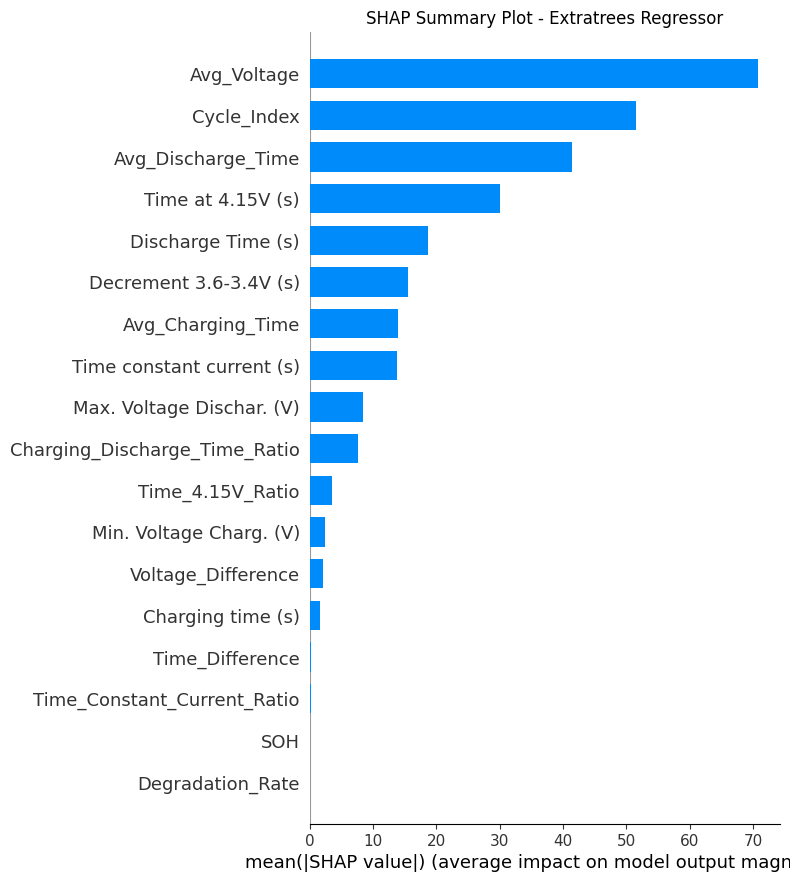

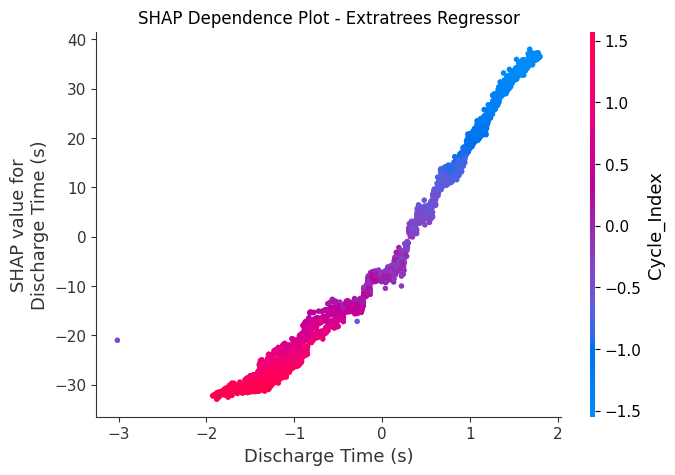

In [54]:
import shap

# grid_search_xgb = GridSearchCV(estimator=xgb_model, param_grid=xgb_param_grid,
#                                scoring='neg_mean_absolute_error', cv=5, verbose=0, n_jobs=-1)
# grid_search_bagging = GridSearchCV(estimator=bagging_model, param_grid=bagging_param_grid ,
#                                scoring='neg_mean_absolute_error', cv=5, verbose=0, n_jobs=-1)
# grid_search_lgbm = GridSearchCV(estimator=lgbm_model, param_grid=lgbm_param_grid ,
#                                scoring='neg_mean_absolute_error', cv=5, verbose=0, n_jobs=-1)
# grid_search_extra_trees = GridSearchCV(estimator=extra_trees_model, param_grid=extra_trees_param_grid ,
#                                scoring='neg_mean_absolute_error', cv=5, verbose=0, n_jobs=-1)

# Get the best estimators from the previous optimization step (assuming they are stored in a dictionary called 'best_estimators')
# best_estimators = {  # Replace with your actual best_estimators dictionary
#     'XGBoost': grid_search_xgb.best_estimator_,
#     'BaggingRegressor': grid_search_bagging.best_estimator_,
#     'LightGBM': grid_search_lgbm.best_estimator_,
#     'ExtraTreesRegressor': grid_search_extra_trees.best_estimator_
# }


# # Create SHAP plots for each model
# for model_name, model in best_estimators.items():

explainer = shap.TreeExplainer(extra_trees_model)
shap_values = explainer.shap_values(X_test)

# Generate summary plot (bar plot)
shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)
plt.title(f"SHAP Summary Plot - Extratrees Regressor")
plt.show()

# Generate dependence plot for a top feature (e.g., 'Discharge Time (s)')
shap.dependence_plot('Discharge Time (s)', shap_values, X_test, show=False)
plt.title(f"SHAP Dependence Plot - Extratrees Regressor")
plt.show()

# Battery Classification - Health, Moderate and Critical

In [23]:
data = pd.read_csv("new_RUL_data.csv")

In [24]:
def classify_battery_health(rul, max_rul):
    if rul > 0.7 * max_rul:
        return "Healthy"
    elif rul >= 0.3 * max_rul:
        return "Moderate Wear"
    else:
        return "Critical Condition"

data["Health_Status"] = data["RUL"].apply(lambda x: classify_battery_health(x, data["RUL"].max()))

# df["Health_Status"] = df["RUL"].apply(lambda x: classify_battery_health(x, df["RUL"].max()))

In [26]:
data["Health_Status"].value_counts()

,count
Health_Status,
Moderate Wear,5137
Healthy,3902
Critical Condition,3592


In [88]:
data.to_csv('RUL_data_health_stat.csv', index=False)

In [91]:
print(data["RUL"].max() *0.7)
print(data["RUL"].max() *0.3)


784.6999999999999
336.3


In [80]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

X = df[numerical_features]  # Features
y = df["Health_Status"]

# Encode categorical labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Save it for future use
joblib.dump(label_encoder, "label_encoder.pkl")

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Train classifier
clf = RandomForestClassifier(max_depth=5,              # Reduce depth
                            min_samples_split=10,     # Force more generalization
                            min_samples_leaf=4,       # Avoid small isolated leaves
                            n_estimators=100,         # Reduce trees
                            bootstrap=True            # Use only subsets of data
                             )
clf.fit(X_train, y_train)



RandomForestClassifier(max_depth=5, min_samples_leaf=4, min_samples_split=10)

Model Accuracy: 0.99

Classification Report:
                    precision    recall  f1-score   support

Critical Condition       0.99      1.00      1.00       832
           Healthy       1.00      0.99      0.99       847
     Moderate Wear       0.99      0.99      0.99      1206

          accuracy                           0.99      2885
         macro avg       0.99      0.99      0.99      2885
      weighted avg       0.99      0.99      0.99      2885



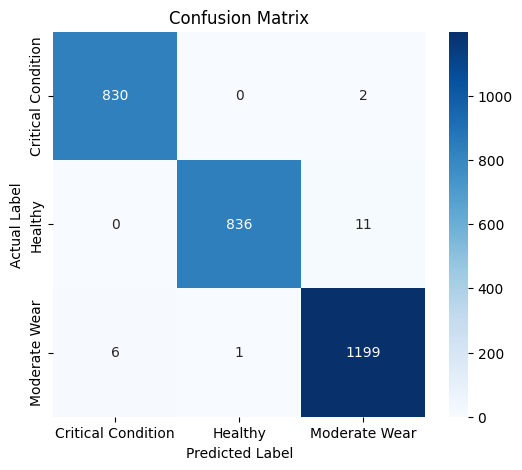

In [77]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import LabelEncoder

# Step 1: Make predictions on the test dataset
y_pred = clf.predict(X_test)  # Predict class labels
y_pred_labels = label_encoder.inverse_transform(y_pred)  # Convert to actual class names
y_test_labels = label_encoder.inverse_transform(y_test)  # Convert test labels to actual names

# Step 2: Calculate Accuracy
accuracy = accuracy_score(y_test_labels, y_pred_labels)
print(f"Model Accuracy: {accuracy:.2f}")

# Step 3: Generate and display the classification report
print("\nClassification Report:")
print(classification_report(y_test_labels, y_pred_labels))

# Step 4: Generate and visualize the confusion matrix
cm = confusion_matrix(y_test_labels, y_pred_labels, labels=label_encoder.classes_)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix")
plt.show()

# Step 5: Plot ROC Curve (only for binary classification)
if len(label_encoder.classes_) == 2:
    y_test_binary = (y_test_labels == "Healthy").astype(int)  # Modify for your positive class
    y_pred_proba = clf.predict_proba(X_test)[:, np.where(label_encoder.classes_ == "Healthy")[0][0]]

    fpr, tpr, _ = roc_curve(y_test_binary, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Random guess line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()


In [73]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy')
print(f"Mean CV Accuracy: {cv_scores.mean():.4f}")

Mean CV Accuracy: 0.9943
